# Discrete time diffusion models

Diffusion models are a class of generative models involved in sequentially corrupting training data with slowly increasing noise, and then learning to reverse this corruption in order to form a generative model of the data. Sohl-Dickstein et. al. introduced these models after taking inspiration from diffusion process models in physics under quadratic/harmonic well or potential, where a particle is gradually drifted towards origin instead of drifting to infinity.

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2764446/1111308752.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])


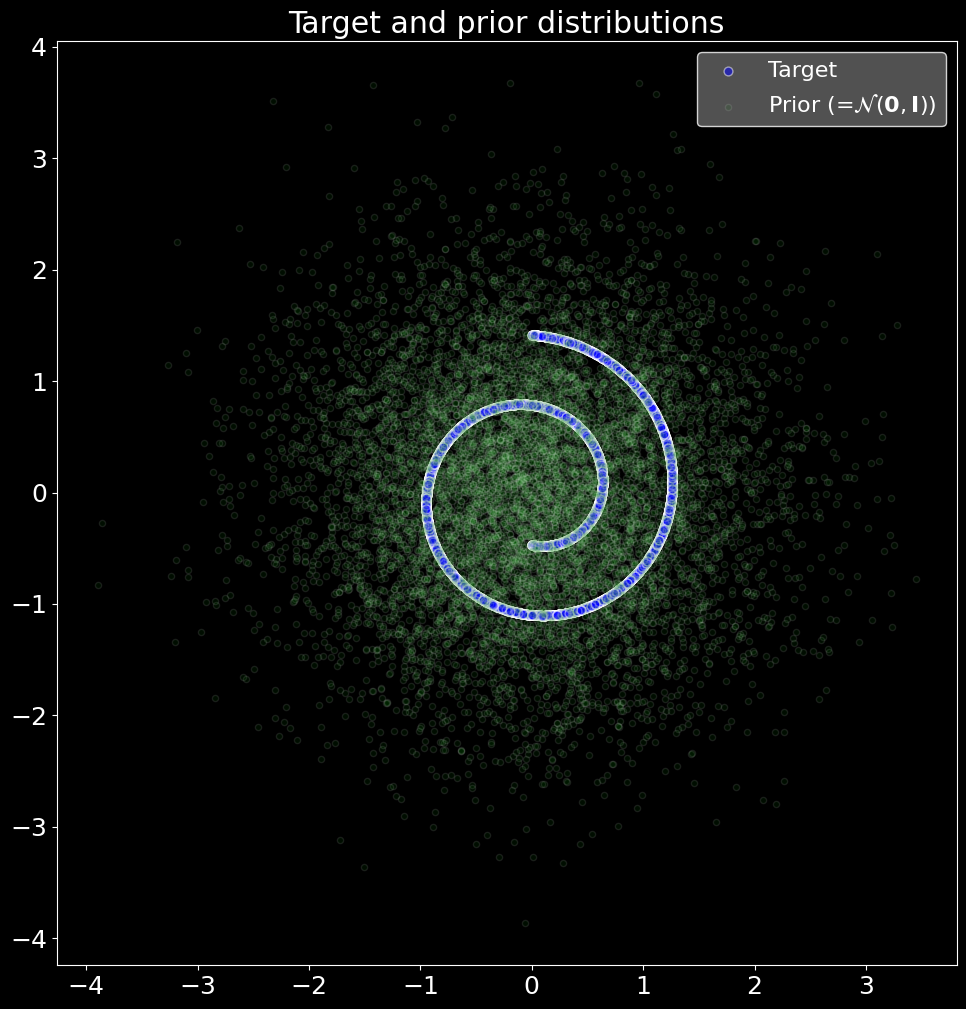

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()
# Sample a batch of datapoints from the swiss roll dataset
def sample_batch(size, noise=0.0):
    x, _= make_swiss_roll(size, noise=noise) #generates size number of points from the swiss roll dataset with added noise of variance 1.0
    return x[:, [0, 2]] / 10.0
    x = (x - x.mean()) / x.std()
# Plot it
data = sample_batch(10**4).T # Generate 10000 points from swiss roll
std_gaussian = np.random.normal(size=(10000, 2))
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(*data, alpha=0.5, color='blue', edgecolor='white', s=40)
ax.scatter(std_gaussian[:, 0], std_gaussian[:, 1], alpha=0.1, color='green', edgecolor='white', s=20)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

## Forward process

Considering a sequence $0 < \beta_1, \beta_2, \cdots, \beta_T< 1$. For each training data point $x_0 \sim p_{data}(x)$, a discrete Markov chain $\{x_0, x_1, \cdots x_T\}$ is constructed such that $p(x_t \mid x_{t-1}) = \mathcal{N}(x_t ; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I)$. The form of the coefficients  are chosen such that the variance of the latent variables stay at a similar scale; in other words, the encoding (forward diffusion) process is variance-preserving. Hence, $q(x_t \mid x_0)=p_{\alpha_t}(x_t \mid x_{0}) = \mathcal{N}(x_t ; \sqrt{\alpha_t} x_{0}, (1-\alpha_t) I)$, where $\alpha_t := \prod_{j=1}^t (1 - \beta_j)$

The following function calculates various $\beta_t$ and $\alpha_t$

In [2]:
def calculate_parameters(diffusion_steps, min_beta, max_beta):
    step = (max_beta - min_beta) / diffusion_steps
    beta_ts = torch.arange(min_beta, max_beta + step, step)

    alpha_ts = 1 - beta_ts
    bar_alpha_ts = torch.cumprod(alpha_ts, dim=0)

    return beta_ts, alpha_ts, bar_alpha_ts

The above code uses the linear noise schedule, which is also what was used in DDPM. 

$x_t$ for any timestep $t$ can be obtained from any initial sample $x_0$ via the following equation:
$$x_t = \sqrt{\alpha_t} x_{0} + (1-\alpha_t) \epsilon \quad \epsilon \sim \mathcal{N}(0, I)$$

$\epsilon$ and $x_t$ are obtained from the following function

In [3]:
def calculate_data_at_certain_time(x_0, bar_alpha_ts, t):
    eps = torch.randn(size=x_0.shape)
    noised_x_t = (
        torch.sqrt(bar_alpha_ts[t]) * x_0 + torch.sqrt(1 - bar_alpha_ts[t]) * eps
    )

    return noised_x_t, eps

The forward process can be visualized by running the following code

In [5]:
import matplotlib.pyplot as plt
import torch
from matplotlib.animation import FuncAnimation

def create_forward_process_animation(x, diffusion_steps, min_beta, max_beta, save_path):
    X = torch.tensor(x, dtype=torch.float32)
    beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(
        diffusion_steps, min_beta, max_beta
    )
    fig, ax = plt.subplots(figsize=(6, 6))
    scatter = ax.scatter([], [], alpha=0.1, s=1)

    def init():
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Forward Process")
        return (scatter,)

    def update(t):
        noised_x_t, eps = calculate_data_at_certain_time(X, bar_alpha_ts, t)
        # Update scatter plot
        scatter.set_offsets(noised_x_t)
        ax.set_title(f"Forward Process - Step {t}/{diffusion_steps}")
        return (scatter,)

    # Create animation
    anim = FuncAnimation(fig, update, frames=diffusion_steps, init_func=init, blit=True)

    # Save animation as video
    anim.save(save_path, writer="pillow", fps=10)
    plt.close(fig)
    print("Finish saving gif file: ", save_path)

In [7]:
sample_num = 100000
noise_std = 0.5
x = sample_batch(sample_num, noise_std)
diffusion_steps = 50
min_beta = 1e-4
max_beta = 0.02
save_path = "forward_process.gif"
create_forward_process_animation(x, diffusion_steps, min_beta, max_beta, save_path)

Finish saving gif file:  forward_process.gif


<img src="forward_process.gif" width="750" align="center">

## Reverse process and Training

### Neural network for training

The original paper uses the U-Net architecture for training, but we use a simpler architecture on the Swiss roll data. 

In [11]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        input_data = torch.hstack([x, t])
        return self.net(input_data)

In [12]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print("Using {0} device".format(device))
model = SimpleNN().to(device)
print(model)

Using cuda device
SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


In the reverse process:

$$q(x_{t-1} \mid x_t) = \mathcal{N}(\mu_\theta(x_t, t), \Sigma_t)$$

For a particular time-step, $\Sigma_t$ doesn't depend on the data and hence is fixed. 

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{1-\beta_t}}(x_t - \frac{\beta_t}{\sqrt{1-\alpha_t}}\epsilon_\theta(x_t, t))$$

$\epsilon_\theta(x_t, t)$ is the network that predicts the source noise $\epsilon \sim \mathcal{N}(0, I)$ that gave us $x_t$ from $x_0$. The training loss is defined as following:

$$L_{\text{simple}} := \mathbb{E}_{t, x_0, \epsilon} \left[ \left| \epsilon - \epsilon_{\theta} \left( \sqrt{{\alpha}_t} x_0 + \sqrt{1 - {\alpha}_t} \epsilon, t \right) \right|^2 \right]$$

The algorithm for training is the following:

**Algorithm 1** Training  

**1:** **repeat**  
**2:** $\quad$ $\mathbf{x}_0 \sim q(\mathbf{x}_0)$  
**3:** $\quad$ $t \sim \text{Uniform}(\{1, \dots, T\})$  
**4:** $\quad$ $\epsilon \sim \mathcal{N}(0, I)$  
**5:** $\quad$ Take gradient descent step on $\nabla_{\theta} \left\| \epsilon - \epsilon_{\theta} \left( \sqrt{{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - {\alpha}_t} \epsilon, t \right) \right\|^2$

**6:** **until** converged  

Parameters used for training are the following: 
```Optimizer -> Adam, Batch size -> 128, Epochs -> 30, Diffusion timesteps -> 50, Minimum beta -> 1e-4, Maximum beta -> 0.02```

In [14]:
def train(
    data,
    batch_size,
    device,
    epochs,
    diffusion_steps,
    min_beta,
    max_beta,
    learning_rate,
    output_model_path,
):
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    model = SimpleNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(
        diffusion_steps, min_beta, max_beta
    )
    for epoch in range(epochs):
        count = 0
        epoch_loss = 0
        for x in data_loader:
            random_time_step = torch.randint(0, diffusion_steps, size=[len(x), 1])
            noised_x_t, eps = calculate_data_at_certain_time(
                x, bar_alpha_ts, random_time_step
            )
            predicted_eps = model.forward(
                noised_x_t.to(device), random_time_step.to(device)
            )
            loss = loss_fn(predicted_eps, eps.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1

        print("Epoch {0}, Loss={1}".format(epoch, round(epoch_loss / count, 5)))

    print("Finished training!!")
    torch.save(model.state_dict(), output_model_path)
    print("Saved model: ", output_model_path)

In [16]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print("Using {0} device".format(device))

sample_num = 100000
noise_std = 0.5
x = sample_batch(sample_num, noise_std)
data = torch.tensor(x, dtype=torch.float32)
batch_size = 128
epochs = 30
diffusion_steps = 50
min_beta = 1e-4
max_beta = 0.02
learning_rate = 1e-3
output_model_path = "diffusion_model.pth"
train(
    data,
    batch_size,
    device,
    epochs,
    diffusion_steps,
    min_beta,
    max_beta,
    learning_rate,
    output_model_path,
)

Using cuda device
Epoch 0, Loss=0.781
Epoch 1, Loss=0.7253
Epoch 2, Loss=0.70105
Epoch 3, Loss=0.68984
Epoch 4, Loss=0.67645
Epoch 5, Loss=0.66588
Epoch 6, Loss=0.66166
Epoch 7, Loss=0.65593
Epoch 8, Loss=0.65236
Epoch 9, Loss=0.64711
Epoch 10, Loss=0.64624
Epoch 11, Loss=0.64611
Epoch 12, Loss=0.64419
Epoch 13, Loss=0.649
Epoch 14, Loss=0.63962
Epoch 15, Loss=0.63946
Epoch 16, Loss=0.64545
Epoch 17, Loss=0.64092
Epoch 18, Loss=0.63743
Epoch 19, Loss=0.64277
Epoch 20, Loss=0.63752
Epoch 21, Loss=0.63718
Epoch 22, Loss=0.6426
Epoch 23, Loss=0.63502
Epoch 24, Loss=0.64188
Epoch 25, Loss=0.63892
Epoch 26, Loss=0.64253
Epoch 27, Loss=0.64235
Epoch 28, Loss=0.63706
Epoch 29, Loss=0.63816
Finished training!!
Saved model:  diffusion_model.pth


### Sampling 

The sample $x_{t-1}$ can be obtained from $x_t$ by the following equation:

$$x_{t-1} = \frac{1}{\sqrt{1-\beta_t}}(x_t - \frac{\beta_t}{\sqrt{1-\alpha_t}}\epsilon_\theta(x_t, t)) + \sigma_t z \quad z \sim \mathcal{N}(0, I)$$

Hence the sampling algorithm is as follows:

**Algorithm 2** Sampling  


**1:** $\quad$ $\mathbf{x}_T \sim \mathcal{N}(0, I)$  
**2:** $\quad$ **for** $t = T, \dots, 1$ **do**  
**3:** $\quad$ $\quad$ $\mathbf{z} \sim \mathcal{N}(0, I)$ if $t > 1$, else $\mathbf{z} = 0$  
**4:** $\quad$ $\quad$ $\mathbf{x}_{t-1} = \frac{1}{\sqrt{1-\beta_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - {\alpha}_t}} \epsilon_{\theta} (\mathbf{x}_t, t) \right) + \sigma_t \mathbf{z}$  
**5:** $\quad$ **end for**  
**6:** $\quad$ **return** $\mathbf{x}_0$  

It is implemented using the following code-snippets

In [17]:
def sampling(model_path, sample_num, diffusion_steps, min_beta, max_beta):
    model = SimpleNN()
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    with torch.no_grad():
        x_init = torch.randn(size=(sample_num, 2))
        beta_ts, alpha_ts, bar_alpha_ts = calculate_parameters(
            diffusion_steps, min_beta, max_beta
        )
        denoised_x = torch.zeros((diffusion_steps, x_init.shape[0], x_init.shape[1]))
        denoised_x[-1] = x_init
        for t in range(diffusion_steps - 1, 0, -1):
            if t > 1:
                z = torch.randn(x_init.shape)
            else:
                z = 0
            ts = torch.full((x_init.shape[0], 1), t)
            mu = (
                1
                / torch.sqrt(alpha_ts[t])
                * (
                    (
                        denoised_x[t]
                        - (1 - alpha_ts[t])
                        / torch.sqrt(1 - bar_alpha_ts[t])
                        * model.forward(denoised_x[t], ts)
                    )
                )
            )
            denoised_x[t - 1] = mu + torch.sqrt(beta_ts[t]) * z

    return denoised_x

In [18]:
def create_sampling_animation(denoised_x, diffusion_steps, save_path):
    fig, ax = plt.subplots(figsize=(6, 6))
    scatter = ax.scatter([], [], alpha=0.1, s=1)

    def init():
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Sampling")
        return (scatter,)

    def update(rev_t):
        # Update scatter plot
        t = diffusion_steps - 1 - rev_t
        scatter.set_offsets(denoised_x[t])
        ax.set_title(f"Sampling - Step {t}/{diffusion_steps}")
        return (scatter,)

    # Create animation
    anim = FuncAnimation(fig, update, frames=diffusion_steps, init_func=init, blit=True)
    # Save animation as video
    anim.save(save_path, writer="pillow", fps=10)
    plt.close(fig)
    print("Finish saving gif file: ", save_path)

In [19]:
model_path = "diffusion_model.pth"
sample_num = 100000
diffusion_steps = 50
min_beta = 1e-4
max_beta = 0.02
denoised_x = sampling(model_path, sample_num, diffusion_steps, min_beta, max_beta)
save_path = "sampling.gif"
create_sampling_animation(denoised_x, diffusion_steps, save_path)

Finish saving gif file:  sampling.gif


<img src="sampling.gif" width="750" align="center">